**тематическое моделирование**

_Евгений Борисов <esborisov@sevsu.ru>_

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

pd.options.display.precision = 2 
pd.options.display.max_colwidth = 200 
tqdm.pandas()

Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation   
http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [2]:
# разложение частотной матрицы [ слова x документы ]  
#
# получаем матрицу с описанием тем [ слова х темы ]   
# и матрицу вероятностей событий "тема описывает документ"  [ темы х документы ]
# 
# [ слова x документы ] = [ слова х темы ] * [ темы х документы ]
# 
# p(w|d) = p(w|t) * p(t|d)

# загрузка данных

In [3]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
display( len(data) )
display( data.sample(2) )

3196

,text,tag
2248,"Пермское региональное управление Следственного комитета инициировало проверку появившейся в СМИ информации о том, что кондуктор выгнала 11-летнего школьника из автобуса не на остановке в мороз из-...",incident
3117,Юлия Маркова ИТАР-ТАСС. Новости культуры (оперативная лента) На Колыме\nуспешно завершился этнокультурный образовательный эксперимент по\nпрограмме поддержки северных народов Администрация Магадан...,social


In [4]:
display( len( data.drop_duplicates('text') ) )

3196

# токенайзер

In [5]:
# NLTK package manager
# import nltk
# nltk.download()

In [6]:
import re
from nltk.tokenize import word_tokenize as nltk_tokenize_word

In [7]:
# def tokenizer(text):
#     return [
#             t for t in nltk_tokenize_word( # разбиваем текст на слова
#                 re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
#                 language='russian'
#             ) 
#         ]

In [8]:
# stemmer = SnowballStemmer('russian')

from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('russian'))

def tokenizer(text,stopwords=stopwords):
    return [
            t for t in nltk_tokenize_word( # разбиваем текст на слова
                re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
                language='russian'
            ) 
            if not (
               False
               or (len(t)<3) # выкидываем очень короткие слова
               or re.match(r'^[^a-zA-ZЁёА-я]+$', t) # выкидываем токены не содержащие букв
               or re.match(r'^(\w)\1+$', t)  # выкидываем токены из одного повторяющегося символа
               or re.match(r'^[^a-zA-ZЁёА-я].*$', t)  # выкидываем токены начинающиеся не с буквы
               or (t in stopwords) # выкидываем предлоги, союзы и т.п.    
            )
        ] 

# выполняем частотный анализ

In [9]:
# from sklearn.feature_extraction.text import CountVectorizer
# tf_model = CountVectorizer(
#         min_df=.01, # выкидываем очень редкие слова
#         max_df=.10, # выкидываем очень частые слова
#         tokenizer=tokenizer, # ф-ция токенайзер
#         token_pattern=None, # отключаем дефолтный токенайзер
#         # binary=True,
#     )

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_model = TfidfVectorizer(
        min_df=.01, # выкидываем очень редкие слова
        max_df=.10, # выкидываем очень частые слова
        use_idf=False, # не используем обратную частоту
        norm='l2', # нормируем TF
        tokenizer=tokenizer, # ф-ция токенайзер
        token_pattern=None, # отключаем дефолтный токенайзер
    )

In [11]:
%%time

data_tf = tf_model.fit_transform( data['text'] )

display(data_tf.shape)

(3196, 2021)

CPU times: user 4.62 s, sys: 13.2 ms, total: 4.63 s
Wall time: 4.64 s


In [12]:
vocab = sorted(tf_model.vocabulary_)
display(len(vocab))
display(vocab)

2021

['adobe',
 'afisha.tut.by',
 'apple',
 'audi',
 'auto.tut.by',
 'facebook',
 'finance.tut.by',
 'flash',
 'html5',
 'http',
 'javascript',
 'journal',
 'kia',
 'lenta.ru',
 'news',
 'player',
 'realty.tut.by',
 'regnum',
 'reuters',
 'sport.tut.by',
 'street',
 'telegram',
 'the',
 'times',
 'tut.by',
 'twitter',
 'volkswagen',
 'wall',
 'youtube',
 'абсолютно',
 'аварии',
 'авария',
 'августа',
 'августе',
 'авто',
 'автобуса',
 'автомобилей',
 'автомобилем',
 'автомобили',
 'автомобиль',
 'автомобиля',
 'автор',
 'авторы',
 'агентства',
 'агентство',
 'администрации',
 'адрес',
 'актер',
 'активно',
 'активность',
 'акции',
 'акций',
 'александр',
 'александра',
 'александром',
 'алексей',
 'алеппо',
 'американская',
 'американские',
 'американский',
 'американских',
 'американского',
 'американской',
 'америки',
 'анализ',
 'аналитики',
 'андрей',
 'андрея',
 'анна',
 'армии',
 'ассоциации',
 'атмосферу',
 'базе',
 'базовой',
 'банк',
 'банка',
 'безопасности',
 'беларуси',
 'белару

# извлечение списка тем и ключевых слов

In [13]:
# извлекаем из модели список тем и ключевых слов
def extract_topics( components, feature_names, n_top_words=3 ):
    return {
        topic_idx : [ feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1] ]
        for topic_idx, topic in enumerate(components)
    }

In [14]:
# from sklearn.decomposition import LatentDirichletAllocation
# # LDA - латентное размещение Дирихле
# tm_model = LatentDirichletAllocation( 
#         n_components=10, 
#         max_iter=5,
#         learning_method='online', 
#         learning_offset=50.,
#         random_state=0, 
#     )

In [15]:
from sklearn.decomposition import NMF
# NMF (generalized Kullback-Leibler divergence) 

tm_model = NMF( 
        n_components=10,
        random_state=1, 
        beta_loss='kullback-leibler', 
        solver='mu', 
        max_iter=1000, 
        l1_ratio=.5 
    )

In [16]:
%%time 

data['topic_id'] = np.argmax( tm_model.fit_transform(data_tf),axis=1)

CPU times: user 6.86 s, sys: 4.7 ms, total: 6.86 s
Wall time: 2.11 s


In [17]:
# список тем и ключевых слов
topics = extract_topics( tm_model.components_, vocab )
display( topics )

{0: ['беларуси', 'tut.by', 'беларусь'],
 1: ['президент', 'президента', 'трамп'],
 2: ['рублей', 'компании', 'долларов'],
 3: ['результате', 'дтп', 'водитель'],
 4: ['версия', 'новый', 'видео'],
 5: ['народов', 'севера', 'коренных'],
 6: ['ученые', 'специалисты', 'алеппо'],
 7: ['савченко', 'украины', 'суд'],
 8: ['место', 'динамо', 'чемпионата'],
 9: ['стал', 'фильм', 'мира']}

---

In [18]:
# распределение текстов по темам
# data.groupby(['topic_id']).size().plot.bar(rot=0)

In [19]:
topics_ = { k:f'{k}: ' + ' | '.join(v) for k,v in topics.items() }
tags = sorted(set(data['tag']))

topic_tags = (
    data[['tag','topic_id']]
    .groupby('topic_id')['tag']
    .apply(lambda t_tags: { t: len([w for w in t_tags if w==t]) for t in tags } )
    .reset_index()
    .rename(columns={'level_1':'tag','tag':'count',})
    .apply(lambda d: d.map(topics_) if d.name =='topic_id' else d)
    .pivot(index='topic_id', columns='tag', values='count')
)

display( topic_tags.style.background_gradient(cmap='Blues') )

tag,auto,culture,economics,health,incident,politics,realty,reclama,science,social,sport,tech,woman
topic_id,,,,,,,,,,,,,
0: беларуси | tut.by | беларусь,27,64,38,13,11,26,40,30,6,55,25,26,30
1: президент | президента | трамп,0,17,26,3,1,331,1,0,0,2,14,2,0
2: рублей | компании | долларов,49,7,157,6,19,16,11,9,20,6,4,65,1
3: результате | дтп | водитель,30,2,1,2,340,7,1,0,2,6,0,5,0
4: версия | новый | видео,140,21,3,6,5,7,0,6,0,10,13,61,0
5: народов | севера | коренных,1,37,45,21,29,75,6,2,3,58,8,27,1
6: ученые | специалисты | алеппо,0,33,1,36,3,39,2,0,196,4,1,57,1
7: савченко | украины | суд,0,8,0,2,27,86,0,0,0,1,8,32,1
8: место | динамо | чемпионата,1,6,0,1,0,2,0,0,0,0,272,3,0


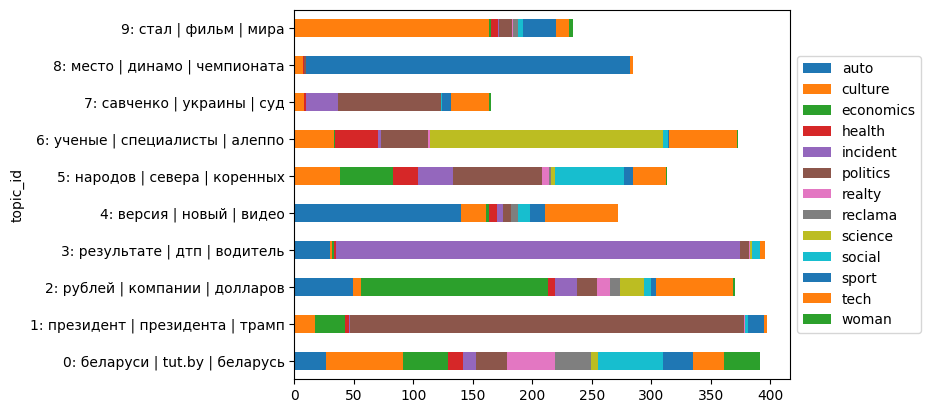

In [20]:
( # распределение количества текстов по темам с долями меток
    topic_tags
    .plot.barh(stacked=True) #,rot=0)
    .legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
)

---

In [21]:
data['keywords'] = data['topic_id'].map(topics)
display( data.sample(4) )

,text,tag,topic_id,keywords
2315,"Сотрудницу полиции, которая стала виновником ДТП с двум погибшими в Подмосковье, уволили из органов внутренних дел, сообщает МВД. Подозреваемая находилась в состоянии алкогольного опьянения. Она з...",incident,3,"[результате, дтп, водитель]"
2763,"Компания Apple добавит второй слот для SIM-карты в новом iPhone, который представят в конце 2017 года, сообщает Gizmochina. В начале 2016 года Apple подала две патентные заявки, одна из которых оп...",tech,4,"[версия, новый, видео]"
1967,"НЬЮ-ЙОРК (Рейтер) - Индексы S&P 500 и Nasdaq Composite снизились в понедельник после шести дней роста из-за падения акций технологического сектора, а ралли энергетических акций сошло на нет, так к...",economics,2,"[рублей, компании, долларов]"
1650,СМИ: Россия выплатит 6 тысяч евро фигуранту дела Немцова\n\nНа аналогичные выплаты могут рассчитывать и другие фигуранты дела\n\nРоссийские власти предложили Темирлану Эскерханову — одному из фигу...,politics,7,"[савченко, украины, суд]"
